In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd
import scipy 

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Hidden Markov Model and LQR
This is an example of learning a HMM over some trajectories demonstrations and reproducing it using optimal control.
More infos : http://calinon.ch/papers/Calinon-JIST2015.pdf, http://calinon.ch/papers/Calinon-HFR2016.pdf


## Learning Hidden Markov Model (HMM)

In [2]:
letter = 'C' # choose a letter in the alphabet

In [3]:
from scipy.io import loadmat # loading data from matlab

datapath = os.path.dirname(pbd.__file__) + '/data/2Dletters/'
data = loadmat(datapath + '%s.mat' % letter)

demos_x = [d['pos'][0][0].T for d in data['demos'][0]] # Position data

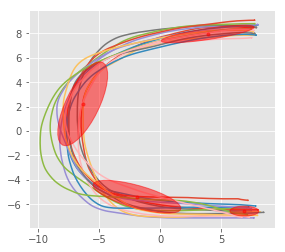

In [4]:
model = pbd.HMM(nb_states=4, nb_dim=2)

model.init_hmm_kbins(demos_x) # initializing model
# EM to train model
# model.em(demos_xdx, reg=1e-3) 
plt.gca().set_aspect('equal')
# position plotting
for p in demos_x:
    plt.plot(p[:, 0], p[:, 1])
    
pbd.plot_gmm(model.mu, model.sigma, dim=[0, 1]); 

### Get sequence of states 

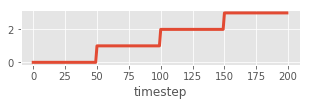

In [109]:
demo_idx = 0
sq = model.viterbi(demos_x[demo_idx])
sq = np.linspace(0, model.nb_states, 201).astype(int)[:-1]
plt.figure(figsize=(5, 1))
# plt.axis('off')
plt.plot(sq, lw=3);
plt.xlabel('timestep');

## Create system and solve LQR 

In order to make loop, we double the system. Instead of having one pen, we control two pen which does each half of the motion. They should also start and end at the same point, with inverse velocity.

In [110]:
# triple integrator for a pen
A, B = pbd.utils.get_canonical(2, 3, 0.01)

In [111]:
# create two parrallel and independent systems (two pen)
A_full = np.zeros((12, 12))
A_full[:6, :6] = A
A_full[6:, 6:] = A
B_full = np.zeros((12, 4))
B_full[:6, :2] = B
B_full[6:, 2:] = B

In [199]:
# split horizon in two
horizon = demos_x[demo_idx].shape[0]

In [200]:
# create a cost for correlating states withing the two systems
def sigma_corr(pos, vel, beta=1e-4):
    std_pos = 3. 
    std_vel, std_acc = 20., 100.
    sigma_end = np.diag([std_pos ** 2,  std_pos ** 2,
                         std_vel ** 2, std_vel ** 2,
                         std_acc ** 2, std_acc ** 2] * 2)
    
    alpha = (1 - beta)
    if pos:
        sigma_end[0, 6] = alpha * std_pos ** 2
        sigma_end[1, 7] = alpha * std_pos ** 2
        sigma_end[6, 0] = alpha * std_pos ** 2
        sigma_end[7, 1] = alpha * std_pos ** 2
    
    alpha = (1 - 1e-5)
    
    if vel:
        sigma_end[2, 8] = -alpha * std_vel ** 2
        sigma_end[8, 2] = -alpha * std_vel ** 2

        sigma_end[3, 9] = -alpha * std_vel ** 2
        sigma_end[9, 3] = -alpha * std_vel ** 2
        
    return sigma_end

In [213]:
# create target sequences by flipping half of the sequence
z = np.concatenate([model.mu[sq], np.zeros((horizon, 4)), 
                    model.mu[np.flip(sq)], np.zeros((horizon, 4))], 1)

# create basis covariance for velocity and acceleration
std_vel, std_acc = 20., 100.
Q_inv = np.zeros((horizon, 12, 12)) + np.diag(
    [0., 0., std_vel ** 2, std_vel ** 2, std_acc ** 2, std_acc ** 2] * 2)

# put position information from the model
Q_inv[:, :2, :2] = model.sigma[sq[:horizon]]
Q_inv[:, 6:8, 6:8] = model.sigma[np.flip(sq)[:horizon]]

# add cost to have same final position and velocity
z[horizon/2] = np.zeros(12)
Q_inv[horizon/2] = sigma_corr(pos=True, vel=False, beta=1e-10)

Q = np.linalg.inv(Q_inv)

# model to give to double LQR
model_double = pbd.GMM(mu=z, lmbda=Q)

In [214]:
# create start constraint xi0_double_pen = C.matmul(xi0_single_pen)
# start constraint
C = np.zeros((12, 6))

# same position
C[0:2, 0:2] = np.eye(2)
C[6:8, 0:2] = np.eye(2)

# inverse velocity
C[2:4, 2:4] = np.eye(2)
C[8:10, 2:4] = -np.eye(2)

# same acceleration 
C[4:6, 4:6] = np.eye(2)
C[10:12, 4:6] = np.eye(2)

In [215]:
lqr = pbd.LQR(A_full, B_full, horizon=horizon)
lqr.gmm_xi = model_double
lqr.gmm_u = 1e12 # variance of derivative of acceleration


lqr.ricatti() # solve LQR

In [216]:
# get initial state of single pen that minimize first command
xi0 = scipy.optimize.lsq_linear(lqr.K[0].dot(C), lqr.cs[0])['x']

In [221]:
# execute rollout
xi, _ = lqr.get_seq(C.dot(xi0))
xi = xi[:horizon/2+1]

## Plotting reproduced trajectory (position and velocity)

In [222]:
# for i in range(3):
#     plt.figure()
#     plt.plot(lqr.ds[:, 0+(i*2):2+(i*2)])
#     plt.gca().set_prop_cycle(None)
#     plt.plot(lqr.ds[:, 6+(i*2):8+(i*2)])

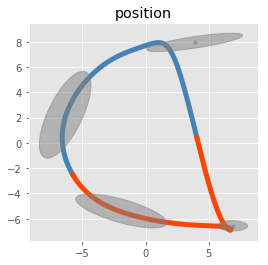

In [223]:
fig, ax = plt.subplots(ncols=1)
ax = [ax]
ax[0].set_aspect('equal')
# position plotting 
ax[0].set_title('position')
# for p in demos_x:
#     ax[0].plot(p[:, 0], p[:, 1], alpha=0.4)
pbd.plot_gmm(model.mu, model.sigma, ax=ax[0], dim=[0, 1], color='grey'); 
    
ax[0].plot(xi[:, 0], xi[:, 1], 'steelblue', lw=5)
ax[0].plot(xi[:, 6], xi[:, 7], 'orangered', lw=5)

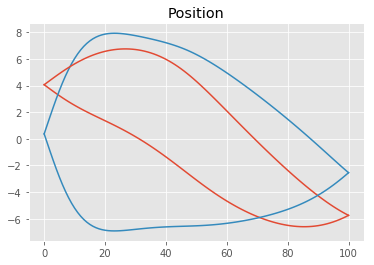

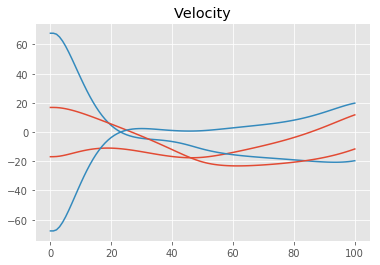

In [224]:
plt.title('Position')
plt.plot(xi[:, :2])
plt.gca().set_prop_cycle(None)
plt.plot(xi[:, 6:8])

plt.figure()
plt.title('Velocity')
plt.plot(xi[:, 2:4])
plt.gca().set_prop_cycle(None)
plt.plot(xi[:, 8:10])

# plt.title('Acceleration')
# plt.figure()
# plt.plot(xi[:, 4:6])
# plt.gca().set_prop_cycle(None)
# plt.plot(xi[:, 10:12])
# # plt.plot(model_double.mu, lw=4, ls='--')